In [15]:
import math

import gym
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from utils import read_config
from model import A3Cff
from environment import atari_env
from ibp import network_bounds


In [2]:
%matplotlib inline

class ArgHelper(object):
    def __init__(self, env, gpu_id, skip_rate, max_episode_length, load_path, env_config):
        self.env = env
        self.gpu_id = gpu_id
        self.skip_rate = skip_rate
        self.max_episode_length = max_episode_length
        self.load_path = load_path
        self.env_config = env_config
        

In [3]:
args = ArgHelper(env = 'PongNoFrameskip-v4',
    gpu_id = 0,
    skip_rate = 4,
    max_episode_length = 10000,
    load_path = 'trained_models/PongNoFrameskip-v4_robust.pt',
    env_config = 'config.json')

In [4]:
def create_env():
    setup_json = read_config(args.env_config)
    env_conf = setup_json["Default"]
    for i in setup_json.keys():
        if i in args.env:
            env_conf = setup_json[i]
    env = atari_env(args.env, env_conf, args)
    return env

In [5]:
if args.gpu_id < 0:
    device = torch.device('cpu')
else:
    device = torch.device('cuda:{}'.format(args.gpu_id))

env = create_env()

In [6]:
current_model = A3Cff(env.observation_space.shape[0], env.action_space)
new_dict = torch.load(args.load_path, map_location=device)
current_model.load_state_dict(new_dict)

current_model = current_model.to(device)

In [7]:
def get_next(curr_model, env, epsilon, state):
    next_snapshots = []
    next_states = []
    input_x = torch.FloatTensor(state).unsqueeze(0).to(device)
    _, output = curr_model.forward(input_x)
    #print(output)
    action = torch.argmax(output, dim=1)

    upper, lower = network_bounds(curr_model.model, input_x, epsilon=epsilon)
    upper, lower = upper[:,1:], lower[:, 1:]
    impossible = upper < torch.max(lower, dim=1)[0]
    
    snapshot = env.ale.cloneState()
    for i in range(impossible.shape[1]):
        if (not impossible[0, i]):
            next_state, reward, done, _ = env.step(i)
            #Won the game, no need to check future states
            if reward > 1e-5:
                env.ale.restoreState(snapshot)
                continue
            #Lost, so worst case is a loss
            elif reward < -1e-5:
                return -1
            else:
                next_snapshots.append(env.ale.cloneState())
                next_states.append(next_state)
                env.ale.restoreState(snapshot)
    return next_snapshots, next_states

def get_greedy_worst_case(curr_model, env, epsilon, state):
    orig_env = env.ale.cloneState()
    while True:
        input_x = torch.FloatTensor(state).unsqueeze(0).to(device)
        _, output = curr_model.forward(input_x)
        #print(output)
        action = torch.argmax(output, dim=1)

        upper, lower = network_bounds(curr_model.model, input_x, epsilon=epsilon)
        upper, lower = upper[:,1:], lower[:, 1:]
        impossible = upper < torch.max(lower, dim=1)[0]
        worst_case_action = torch.argmin(output+1e6*impossible, dim=1)
        next_state, reward, done, _ = env.step(worst_case_action[0])
        
        if abs(reward) > 1e-5:
            env.ale.restoreState(orig_env)
            #print("Greedy worst case reward: {}".format(reward))
            return reward
        
        else:
            state = next_state

def get_action_cert_rate(curr_model, env, epsilon, state):
    certified = 0
    total = 0
    orig_env = env.ale.cloneState()
    while True:
        input_x = torch.FloatTensor(state).unsqueeze(0).to(device)
        _, output = curr_model.forward(input_x)
        #print(output)
        action = torch.argmax(output, dim=1)

        upper, lower = network_bounds(curr_model.model, input_x, epsilon=epsilon)
        upper, lower = upper[:,1:], lower[:, 1:]
        
        upper[:, action] = -1e10    
        max_other = torch.max(upper, dim=1)[0]
        if lower[:, action] > max_other:
            certified += 1
        total += 1
        
        action = torch.argmax(output, dim=1)
        
        next_state, reward, done, _ = env.step(action[0])
        
        if abs(reward) > 1e-5:
            env.ale.restoreState(orig_env)
            return certified/total
        
        else:
            state = next_state

def worst_case_reward(curr_model, env, epsilon):
    envs_to_check = []
    states_to_check = []
    
    state = env.reset()
    pos_rewards = 0
    neg_rewards = 0
    paths = 1
    with torch.no_grad():
        #play through first game
        while True:
            input_x = torch.FloatTensor(state).unsqueeze(0).to(device)
            _, output = curr_model.forward(input_x)
            #print(output)
            action = torch.argmax(output, dim=1)
            next_state, reward, done, _ = env.step(action)
            if reward > 1e-5:
                pos_rewards += 1
            elif reward < -1e-5:
                neg_rewards += 1
            #early stopping
            if max(pos_rewards, abs(neg_rewards)) >= 1:
                envs_to_check.append(env.ale.cloneState())
                states_to_check.append(next_state)
                break
            state = next_state
            
        greedy_reward = get_greedy_worst_case(curr_model, env, epsilon, state)
        acr = get_action_cert_rate(curr_model, env, epsilon, state)
        
        while len(envs_to_check)>0:
            
            env.ale.restoreState(envs_to_check.pop(-1))
            out = get_next(curr_model, env, epsilon, states_to_check.pop(-1)) 
            if out == -1:
                return -1, greedy_reward, paths, acr
            else:
                next_envs, next_states = out
                envs_to_check.extend(next_envs)
                states_to_check.extend(next_states)
                paths += max(0,len(next_envs)-1)
            #if (len(next_envs)-1) > 0 and paths%500==0:
                
            if paths > 5000:
                print(paths, len(envs_to_check))
                return 0, greedy_reward, paths, acr
        return 1, greedy_reward, paths, acr

In [8]:
%%time
verified_rewards = []
greedy_rewards = []
acrs = []
epsilons = np.array([1, 1.1, 1.15, 1.2, 1.3])/255
#np.array([0.1, 0.3, 1, 1.1, 1.15, 1.2, 1.3, 3, 8])/255


for epsilon in epsilons:
    verified = []
    greedy = []
    acr = []
    print('Epsilon: {}'.format(epsilon))
    for j in range(20):
        env = create_env()
        reward, greedy_reward, paths, acr_res = worst_case_reward(current_model, env, epsilon)
        print('Greedy: {}, Absolute worst case reward:{}, paths checked:{}, action cert rate:{:.4f}'.format(greedy_reward,
                                                                                                     reward, paths, acr_res))
        #only count ones where we get absolute worst case result
        if reward != 0:
            verified.append(reward)
            greedy.append(greedy_reward)
            acr.append(acr_res)
    verified_rewards.append(verified)
    greedy_rewards.append(greedy)
    acrs.append(acr)

Epsilon: 0.00392156862745098
Greedy: 1.0, Absolute worst case reward:1, paths checked:3, action cert rate:0.9792
Greedy: 1.0, Absolute worst case reward:1, paths checked:3, action cert rate:0.9792
Greedy: 1.0, Absolute worst case reward:1, paths checked:3, action cert rate:0.9792
Greedy: 1.0, Absolute worst case reward:1, paths checked:3, action cert rate:0.9792
Greedy: 1.0, Absolute worst case reward:1, paths checked:3, action cert rate:0.9792
Greedy: 1.0, Absolute worst case reward:1, paths checked:1, action cert rate:1.0000
Greedy: 1.0, Absolute worst case reward:1, paths checked:2, action cert rate:0.9767
Greedy: 1.0, Absolute worst case reward:1, paths checked:2, action cert rate:0.9767
Greedy: 1.0, Absolute worst case reward:1, paths checked:3, action cert rate:0.9792
Greedy: 1.0, Absolute worst case reward:1, paths checked:1, action cert rate:1.0000
Greedy: 1.0, Absolute worst case reward:1, paths checked:1, action cert rate:1.0000
Greedy: 1.0, Absolute worst case reward:1, path

Greedy: -1.0, Absolute worst case reward:-1, paths checked:104, action cert rate:0.0000
Greedy: -1.0, Absolute worst case reward:-1, paths checked:104, action cert rate:0.0000
Greedy: -1.0, Absolute worst case reward:-1, paths checked:96, action cert rate:0.0000
Greedy: -1.0, Absolute worst case reward:-1, paths checked:98, action cert rate:0.0000
Greedy: -1.0, Absolute worst case reward:-1, paths checked:104, action cert rate:0.0000
Greedy: -1.0, Absolute worst case reward:-1, paths checked:96, action cert rate:0.0000
Greedy: -1.0, Absolute worst case reward:-1, paths checked:104, action cert rate:0.0000
Wall time: 44min 14s


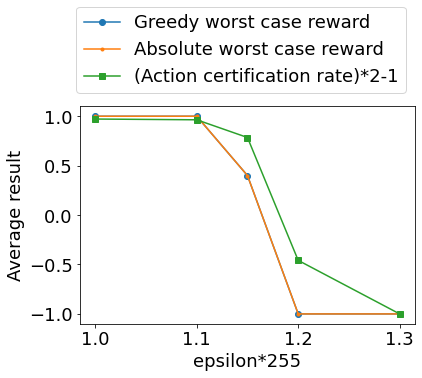

In [25]:
font = {'size'   : 18}

matplotlib.rc('font', **font)
#greed = np.sort(greedy_rewards, axis=1)

#ver = np.sort(verified_rewards, axis=1)
#acr_ = np.sort(acrs, axis=1)

#plt.plot(epsilons, np.mean(greed, axis=1), marker='o', label='greedy mean')
#plt.fill_between(epsilons, greed[:, -1], greed[:, 0], alpha=0.2, label='greedy interval')

#plt.plot(epsilons, np.mean(ver, axis=1), marker='x', label='absolute worst case mean')
#plt.fill_between(epsilons, ver[:, -1], ver[:, 0], alpha=0.2, label='greedy interval')

#plt.plot(epsilons, np.mean(acrs, axis=1)*2-1, marker='+', label='(action certification rate)*2-1')

greed = [np.mean(i) for i in greedy_rewards]
ver = [np.mean(i) for i in verified_rewards]
acr_ = [np.mean(i) for i in acrs]

plt.plot(epsilons*255, greed, marker='o', label='Greedy worst case reward')
plt.plot(epsilons*255, ver, marker='.', label='Absolute worst case reward')
plt.plot(epsilons*255, np.array(acr_)*2-1, marker='s', label='(Action certification rate)*2-1')

plt.legend(bbox_to_anchor=[1,1.5])
plt.xlabel('epsilon*255')
plt.ylabel('Average result')
#plt.xscale('log')
plt.show()

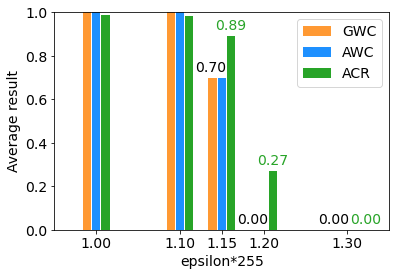

In [139]:
font = {'size'   : 14}
matplotlib.rc('font', **font)

x = epsilons*255 # the label locations
width = 0.01  # the width of the bars

fig, ax = plt.subplots()
#gwc_color = np.array((255,153,51))/255
#pgd_color = np.array((30,144,255))/255
#fgsm_color = np.array((40,164,40))/255

rects1 = ax.bar(x - width - 0.001, (np.array(greed)+1)/2, width, label='GWC', color=np.array((255,153,51))/255)
rects2 = ax.bar(x, (np.array(ver)+1)/2, width, label='AWC', color=np.array((30,144,255))/255)
rects3 = ax.bar(x + width + 0.001, acr_, width, label='ACR', color=np.array((40,164,40))/255)

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Average result')
ax.set_xlabel('epsilon*255')
plt.ylim(0,1)
plt.xlim(0.95,1.35)
#ax.set_title('Scores by group and gender')
ax.set_xticks(x)
ax.legend()


'''def autolabel(rects, color='b', offset=(0,3)):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{:.2f}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=offset,  # 3 points vertical offset
                    textcoords="offset points", color=color,
                    ha='center', va='bottom')'''

def label(rect, color=(0,0,0), offset=(0,3)):
    height = rect.get_height()
    ax.annotate('{:.2f}'.format(rect.get_height()),
                        xy=(rect.get_x() + rect.get_width() / 2, rect.get_height()),
                        xytext=offset,  # 3 points vertical offset
                        textcoords="offset points", color=color,
                        ha='center', va='bottom')
    
label(rects1[2], offset=(-2,3))
label(rects1[3], offset=(-2,3))
label(rects1[4], offset=(-5,3))

label(rects3[2], np.array((40,164,40))/255)
label(rects3[3], np.array((40,164,40))/255)
label(rects3[4], np.array((40,164,40))/255, (9,3))
#autolabel(rects1, np.array((30,144,255))/255, (-6,3))
#autolabel(rects2, np.array((255,153,51))/255, (-12,15))
#autolabel(rects3, np.array((40,164,40))/255, (8,3))

#fig.tight_layout()

plt.show()

In [10]:
for i in range(len(epsilons)):
    print(epsilons[i]*255, len(greedy_rewards[i]))
               

1.0 20
1.1 20
1.15 20
1.2 6
1.3 20


In [43]:
def result_with_eps(eps_index):
    pos_acrs = []
    pos_gwcs = []
    neg_acrs = []
    neg_gwcs = []

    for i in range(len(verified_rewards[eps_index])):
        if verified_rewards[eps_index][i]==1:
            pos_acrs.append(acrs[eps_index][i])
            pos_gwcs.append(greedy_rewards[eps_index][i])
            
        elif verified_rewards[eps_index][i]==-1:
            neg_acrs.append(acrs[eps_index][i])
            neg_gwcs.append(greedy_rewards[eps_index][i])
        
    print('Epsilon: {}/255'.format(epsilons[eps_index]*255))
    print('Average total AWC:{} GWC:{} ACR:{}'.format(np.mean(verified_rewards[eps_index]), 
                                                      np.mean(greedy_rewards[eps_index]), np.mean(acrs[eps_index])))
    print('Positive AWC: {}/20'.format(len(pos_acrs)))
    print('Average pos GWC:{} ACR:{}'.format(np.mean(pos_gwcs), np.mean(pos_acrs)))
    print('Negative AWC: {}/20'.format(len(neg_acrs)))
    print('Average neg GWC:{} ACR:{}'.format(np.mean(neg_gwcs), np.mean(neg_acrs)))
    print('')

In [44]:
for i in range(len(epsilons)):
    result_with_eps(i)

Epsilon: 1.0/255
Average total AWC:1.0 GWC:1.0 ACR:0.9858527131782944
Positive AWC: 20/20
Average pos GWC:1.0 ACR:0.9858527131782944
Negative AWC: 0/20
Average neg GWC:nan ACR:nan

Epsilon: 1.1/255
Average total AWC:1.0 GWC:1.0 ACR:0.9820384073291049
Positive AWC: 20/20
Average pos GWC:1.0 ACR:0.9820384073291049
Negative AWC: 0/20
Average neg GWC:nan ACR:nan

Epsilon: 1.15/255
Average total AWC:0.4 GWC:0.4 ACR:0.8924462649753346
Positive AWC: 14/20
Average pos GWC:1.0 ACR:0.8731375213933352
Negative AWC: 6/20
Average neg GWC:-1.0 ACR:0.9375

Epsilon: 1.2/255
Average total AWC:-1.0 GWC:-1.0 ACR:0.2708333333333333
Positive AWC: 0/20
Average pos GWC:nan ACR:nan
Negative AWC: 6/20
Average neg GWC:-1.0 ACR:0.2708333333333333

Epsilon: 1.3/255
Average total AWC:-1.0 GWC:-1.0 ACR:0.0
Positive AWC: 0/20
Average pos GWC:nan ACR:nan
Negative AWC: 20/20
Average neg GWC:-1.0 ACR:0.0

